## Logistic	Regression	vs.	Bayesian Classifier

Load Task1E_train.csv and Task1E_test.csv as well as the Bayesian classifier(BC) and logistic regression (LR) codes	from	Activities	2 and 3 in Module	3.

In [1]:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2) #Visualisation of data
library(reshape2) #reshape the dataset

Warning message:
"package 'mvtnorm' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
#Import the dataset for the task
train <- read.csv("Task1E_train.csv")
test <- read.csv("Task1E_test.csv")

#Split the file
train_data <- train[,-3]
train_label <- train[,3]
test_data <- test[,-3]
test_label <- test[,3]

#Label each can use either train/test_label since they got the same classes
c1<-unique(train_label)[2] #Class1 or c0
c2 <- unique(train_label)[1] #Class2 or c1

### Bayesian Classifier

These are the steps to build a bayesian Classifier (derieved from jupyter notebook:activity 3.2):
<ol>
	<li>Calculate the class priors $p(\mathcal{C}_k)$ based on the relative number of training data in each class,</li>
	<li>Calculate the class means $\mu_k$, class covariance matrices $\mathbf{S}_k$ and shared covariance matrix $\Sigma$ using the training data,</li>
	<li>Using the estimated PDF function, calculate $p(x_n|\mathcal{C}_k)$ for each data point and each class,</li>
	<li>For each test sample, find the class label $\mathcal{C}_k$ that maximizes the $p(\mathcal{C}_k)p(x_n|\mathcal{C}_k)$,</li>
</ol>

In the following we take these steps one by one as the following below:

In [3]:
bayes_classifier <- function(train_set,class1,class2,train_lab,test_set,test_lab){
    
    #Calculate probability of the class in train dataset
    pc1.hat <- sum(train_lab==class1)/nrow(train_set) #probability of getting c1
    pc2.hat <- sum(train_lab==class2)/nrow(train_set) #probability of getting c2
    
    #Calculate class mean
    muc1.hat <- colMeans(train_set[train_lab==class1,])
    muc2.hat <- colMeans(train_set[train_lab==class2,])
    
    #Calculate class variance and shared covariance matrix
    sigma_c1_hat <- var(train_set[train_lab==class1,]) #variance of class1
    sigma_c2_hat <- var(train_set[train_lab==class2,]) #variance of class2
    
    sigma.hat <- pc1.hat * sigma_c1_hat + pc2.hat * sigma_c2_hat #Shared covariance matrix
    
    #Calculate the posterior probability based on the calculation above
    posterior_c1 <- pc1.hat*dmvnorm(x=train_set, mean=muc1.hat, sigma=sigma.hat)
    posterior_c2 <- pc2.hat*dmvnorm(x=train_set, mean=muc2.hat, sigma=sigma.hat)
    
    # calculate predictions:
    train.predict <- ifelse(posterior_c1 > posterior_c2, class1, class2)
    test.predict <- ifelse(pc1.hat*dmvnorm(x=test_set, mean=muc1.hat, sigma=sigma.hat) > 
                           pc2.hat*dmvnorm(x=test_set, mean=muc2.hat, sigma=sigma.hat), class1, class2)
    
    #Error calculation
    train_error <- 1 - sum(train_lab==train.predict)/nrow(train_set)
    test_error <- 1 - sum(test_lab==test.predict)/nrow(test_set)
    
    return(c(train_error,test_error))

}

### Logistic Regression

Taking the following steps is neccesseary to build a logistic regression (derieved from jupyter notebook:activity 3.3):
<ol>
	<li>Implement sigmoid function $\sigma(\pmb{w}.\mathbf{x})$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and stopping criterion $\epsilon$.</li>
	<li>Repeat the followings until the improvement becomes negligible (i.e., $|\mathcal{L}(\pmb{w}^{(\tau+1)})-\mathcal{L}(\pmb{w}^{(\tau)})| \lt \epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} - \eta (\sigma(\pmb{w}.\mathbf{x}) - t_n) \pmb{x}_n$</li>
</ol>
</li>
</ol>
</li>
</ol>

In the followings, we implement each of these steps.

#### Auxilary Function & Sigmoid function

Similar to other regression model, the auxilary function for calculate the outcome and the error is created as the following:

In [4]:
# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}


# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

In [5]:
logistic_reg <- function(train_set,train_lab,test_set,test_lab,c0,c1){
    # Initializations
    tau.max <- 1000 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE
    
    ## Just a few name/type conversion to make the rest of the code easy to follow
    train_mat <- as.matrix(train_set) # rename just for conviniance
    train_l <- ifelse(train_lab==c0,0,1) # rename just for conviniance

    
    W <- matrix(,nrow=tau.max, ncol=(ncol(train_mat)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)
    
    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],train_mat)
    
    costs <- data.frame('tau'=1:tau.max)  # to be used for trace the cost in each iteration
    costs[1, 'cost_train'] <- cost(W[1,],train_mat,train_l, 0)
    
    while(!terminate){
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],train_mat,train_l, 0)<=epsilon
        
        # shuffle data:
        train_index <- sample(1:nrow(train_set), nrow(train_set), replace = FALSE)
        train_mat <- train_mat[train_index,]
        train_l <- train_l[train_index]
        
        # for each datapoint:
        for (i in 1:nrow(train_set)){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],train_mat,train_l, 0) <=epsilon) {terminate<-TRUE;break}
            
            Y <- sigmoid(W[tau,],train_mat)
            
            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-train_l[i]) * cbind(1, t(train_mat[i,]))
            
            # record the cost:
            costs[(tau+1), 'cost_train'] <- cost(W[tau,],train_mat,train_lab, 0)
            
            # update the counter:
            tau <- tau + 1
            
            # decrease learning rate:
            eta = eta * 0.999
        }
    }
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)
    # the  final result is:
    w <- W[tau,]
    #Error calculation
    train_pred <- predict(w,train_set,c0,c1)
    test_pred <- predict(w,test_set,c0,c1)
    train_error <- 1-sum(train_lab==train_pred)/nrow(train_set)
    test_error <- 1 - sum(test_lab==test_pred)/nrow(test_set)
    
    return(c(train_error,test_error))
}

Using the	 first 5 data points from the training set, train a BC and	 a LR model, and compute their test errors. In a “for loop”, increase	the	size	of training set	(5 data points at a time), retrain the models and calculate their test	errors until all training data points are used. In one figure, plot the	test	errors	for	each	model	(with	different	colors)	versus	the	size	of	the training	set;	include	the	plot	in	your	Jupyter	Notebook	file	
for	Question	7.

In [6]:
set.seed(80)
j = 1 #counter for each row that contain vector of logistic or bayes error
#Store the testing error as vector
logi_test_error <- c()
bayes_test_error <- c()


for (i in seq(5,to=nrow(train_data),by=5)){#For each data point start from five to all of data point moving by 5
    #Train logistic regression model
    logi_error_cal <- logistic_reg(train_data[1:i,], train_label[1:i], test_data, test_label,c1,c2)
    logi_test_error[j] <- logi_error_cal[2] #store error from testing set based on the result of model prediction
    
    #Train bayesian classifier model
    bayes_error <- bayes_classifier(train_data[1:i,],c1,c2,train_label[1:i], test_data, test_label)
    bayes_test_error[j] <- bayes_error[2] #store error from testing set based on the result of model prediction
    
    j=j+1 #Increment of counter until the loop is end
}

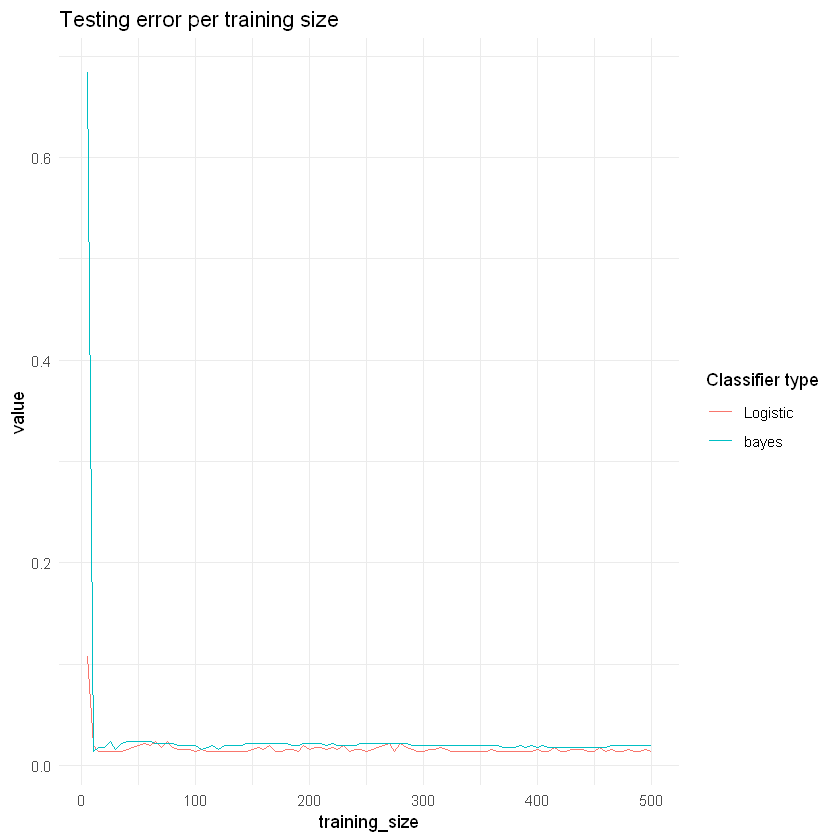

In [7]:
#Create dataframe for the plot
test_error <- data.frame('training_size'=seq(5,to=nrow(train_data),by=5),'Logistic'=logi_test_error,'bayes'=bayes_test_error)
test_error.melt <- melt(test_error,id='training_size') #Change form of the dataframe

#Plot the test error per training size
ggplot(test_error.melt,aes(x = training_size,y = value,color = variable)) +  geom_line()+
scale_color_discrete(guide = guide_legend(title = 'Classifier type')) + theme_minimal()+ggtitle("Testing error per training size")


a. What does happen for the LR and BC respectively when the	number of training data	points	is	increased?

Answer: The error in classification is decreased in a similar pattern for both LR and BC model.

b. Which classifier is best suited when the training set is small, and which	is	best	suited	when	the	training	set	is	big?

Answer:Based on the plot, it seems that LR is suitable for small training set. However, in general, it is difficult to tell which model is better when the data size is very small because they will both perform poorly in prediction.

c. Justify your observations in previous questions (III.a &	 III.b)	 by providing	some	speculations	and	possible	reasons.Hint: Think about model complexity and the fundamental concepts	of	machine	learning	covered	in	Module	1.

Answer: The reason for the plot to illustrate the following pattern because increasing the sample size(training size) will decrease the error causing by an overfitting (model is too complex) due to an increase in parameter of classifier model (non-parametric) along with increasing of training size. Therefore, increasing training size wil reduce error rate (Chen,2022a). 

### References

All the code,algorithm and answer of the question is derieved from the following sources:

- Chen, B. (2022a). $\textit{Week 1.:Elements of Machine Learning}$ \[PowerPoint slides]. https://lms.monash.edu/mod/resource/view.php?id=9894948 
- Chen, B. (2022b). $\textit{Week 6.: Linear Models for Classification(Part B)}$ \[PowerPoint slides]. https://lms.monash.edu/mod/resource/view.php?id=9895008
- Jupyter Notebooks:FIT5201 Machine Learning, (nd.). $\textit{Activity 3.2 Bayesian Classifier}$. 
https://lms.monash.edu/mod/folder/view.php?id=10133948
- Jupyter Notebooks:FIT5201 Machine Learning, (nd.). $\textit{Activity 3.3 Logistic Regression}$. 
https://lms.monash.edu/mod/folder/view.php?id=10133948